# Moteur de recommandation de films

L’objectif de ce notebook est de créer un moteur de recommandation de films à l’aide des méthodes non supervisées.  
Le data set de travail est une base d’environ 5000 films issue d'[IMDB](https://fr.wikipedia.org/wiki/Internet_Movie_Database)  
Le moteur devra être capable de retourner 5 recommandations de films susceptibles de plaire à l’utilisateur, cela à partir d’une requête d’un nom ou un id de film.

Ne disposant pas de l'historique des choix d'utilisateurs, je ne peux pas envisager de faire un moteur de type [filtrage collaboratif](https://fr.wikipedia.org/wiki/Filtrage_collaboratif) et dans quel cas la recommandation se base sur l’historique de l’utilisateur et ceux d’individus ayant un profile similaire .


Dans la mesure où j'ai seulement des informations concernant les films, une approche [basée sur le contenu](https://fr.wikipedia.org/wiki/Syst%C3%A8me_de_recommandation)  s’y prête  bien.


In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from biokit.viz import corrplot

In [2]:
# fonction générant à chaque appel une valeur numérique différente
symbole = 1
def gen_symbole():
    global symbole 
    symbole = symbole + 1
    return symbole

In [3]:
# lecture de fichier csv contenant la donnée.
movies = pd.read_csv('movie_metadata.csv', sep=',', low_memory=False)
print("Avant suppression des doublons", movies.shape)

# suppression des doublons
movies.drop_duplicates(inplace=True)

# réarrangement des index suite à la suppression des doublons.
movies = movies.reset_index(drop=True)

# aperçu de la donnée.
print("Après suppression des doublons", movies.shape)
movies.head(3)

Avant suppression des doublons (5043, 28)
Après suppression des doublons (4998, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000


# Etat de la donnée

Dans la représentation et le tableau ci-dessous, on voit bien que l’état du data set est «**propre**», dans  
la mesure où le taux de remplissage est très élevé , du moins pour les variables qui m’intéressent dans la suite de ce notebook.

Toutes les variables que je vais utiliser sont renseignées à au moins **96.95%** (mots clés)  
Je gérerai **les valeurs manquantes** au besoin quand je construirai les notions de « **distance** » et « **popularité** »

Quant aux «**outliers**»,  comme on va le voir par la suite, l’ensemble des variables utilisées dans la construction de la notion de similarité sont **qualitatives**,  je n’avais donc pas à les traiter.


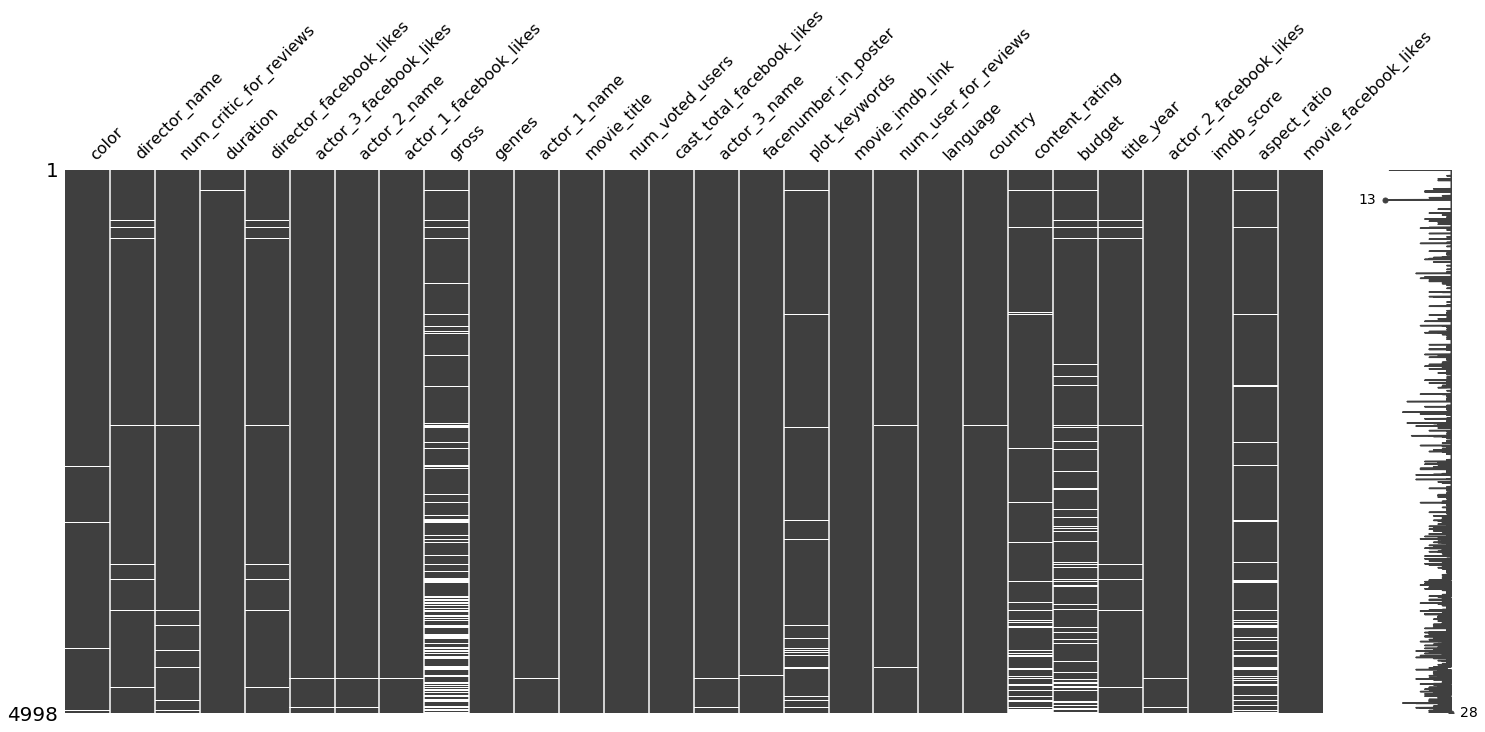

In [4]:
# visualisation globale des "valeurs" manquante.
msno.matrix(movies)

In [229]:
manquant_df = movies.isnull().sum(axis=0).reset_index()
manquant_df.columns = ['colonne', 'manquant']
manquant_df['taux_remplissage'] = (movies.shape[0] - manquant_df['manquant']) / movies.shape[0] * 100
manquant_df.sort_values('taux_remplissage').reset_index(drop = True)

,colonne,manquant,taux_remplissage
0,gross,874,82.513005
1,budget,487,90.256102
2,aspect_ratio,327,93.457383
3,content_rating,301,93.977591
4,plot_keywords,152,96.958784
5,title_year,107,97.859144
6,director_name,103,97.939176
7,director_facebook_likes,103,97.939176
8,num_critic_for_reviews,49,99.019608
9,actor_3_facebook_likes,23,99.539816


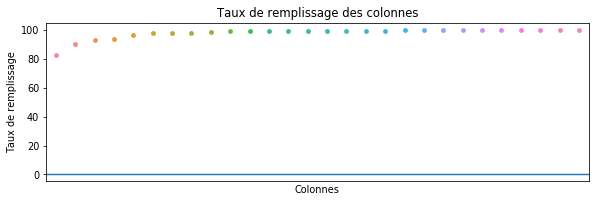

In [231]:
import seaborn as sns
tmp=pd.DataFrame()
tmp['col']=list(manquant_df['colonne'])
tmp['fill_ratio']=list(manquant_df['taux_remplissage'])
tmp.sort_values(by='fill_ratio',inplace=True)
plt.figure(figsize=(10,3))
sns.stripplot(x='col', y='fill_ratio', data=tmp)
plt.axhline(y=0.3)
plt.xticks([])
plt.xlabel('Colonnes')
plt.ylabel('Taux de remplissage')
plt.title('Taux de remplissage des colonnes')
plt.show()

# Construction de la distance

Le moteur doit recommander 5 films similaires...  
Dans mon cas, que veut dire deux films similaires ?  
Si je dispose de  deux films « similaires de la même manière » à celui fourni par l’utilisateur, alors quel film doit « **prioriser** » le moteur ?  

Il en résulte, que l'on doit pouvoir :  
- Quantifier la **similarité** entre les films
- Et - à une ressemblance égale -  **prioriser**  si l’on veut.  

Dans la suite, je vais :
- Définir une  **distance mathématique normée** (*comprise entre 0 et 1*) entre deux films, cela répond au premier  
besoin, dans la mesure où si **d** est une telle distance, la similarité entre deux films, f1, f2 peut se mesurer  
par la quantité ***1 -  d (f1, f2)***  
La distance augmente quand la similarité diminue et inversement.
- Modéliser la notion de **popularité** pour répondre au deuxième point. Le moteur peut ainsi – *à distance égale*  
par rapport à un film F - recommander le film le plus **populaire** .

Les gens préfèrent-t-ils des films selon le genre ? les acteurs ? la période ? Où bien en se basant sur une  
ressemblance (présumée) dans l’histoire via les mots clés … ?

En conséquence, pour définir la distance, je vais devoir faire un choix – forcement subjectif - :  
Je ne considère que les champs relatifs aux : acteurs, réalisateur, genres, mots clés, période de production (plages de 5 années) et pays.  

La totalité de ces variables étant **qualitatives**, il m'a semblé peu pratique d'opter pour une distance euclidienne !

(D’autres variables, notament **quantitatives**, seront utilisés dans la suite pour modéliser la notion de popularité)

La [distance de Hamming](https://fr.wikipedia.org/wiki/Distance_de_Hamming), sert à quantifier la différence (et par conséquence la similarité !) entre deux objets, représentés chacun par une séquence finie de **N** symboles (*un **vecteur** de taille N*)  
Elle mesure cette différence en se basant sur le nombre de symboles **non-concordants**.

Cette distance est fournie dans **sklearn** (la fonction [Hamming_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html) dans le module **sklearn.metrics**), mais pour  
simplifier l’explication ci-dessous, je considère une distance de Hamming normée au sens général, je détaillerai plus tard  les adaptations faites, dues  à l’implémentation dans sklearn. 

La distance entre deux objets  ayant ***n*** points en commun sera donc égale à  ***1 – (n / N)***


Dans le data set, il y’a 26 « genres » différents, et chaque film peut avoir au maximum 5 mots clés associés, mais  
pour les mêmes raisons de simplicité déjà évoqués, dans l'exemple « artificiel » ci-dessous, je considère 4 genres et 3 mots clés.

| acteur 1 | acteur 2 | acteur 3 | réalisateur | horreur | action | comedie | amour | mot clé 1 | mot clé 2 | mot clé 3 | période | pays |
|----------|----------|----------|-------------|---------|--------|---------|-------|-----------|-----------|-----------|---------|------|
| Tom      | Peter    | Emma     | Mark        |         | 1      |         | 1     | amour     | crime     |           | 5       | France  |
| Chris    | Tom      | Tony     | Mark        |         | 1      |         |      | crime     | espion    |  prison      | 10      | France  |
Les deux films ne coïncident (point par point) que sur trois points (réalisateur, genre action et pays) et  la distance de Hamming les séparant est  
1 – 3/13 = 0 .769 

Bien que, la distance de Hamming convient bien aux variables relatives aux genres, période et pays :  
- Elle ne convient pas pour mesurer la distance apportée par les mots clés des deux films.   
- Elle ne « capte » pas **entièrement** la similarité apportée par les variables acteur 1, acteur 2 et acteur 3 dans la mesure où  elle ne tient pas compte du fait que « Tom » joue le premier rôle dans le film 1 et le deuxième rôle dans le film 2.   
- Toutes les variables sont considérées avec la même importance, or je souhaite qu’une coïncidence dans la variable acteur 1  apporte le double de similarité qu’une coïncidence dans la variable 2, et 3 fois la similarité par laquelle contribue la coïncidence en un mot clé.

En utilisant la distance de **Hamming**, on peut remédier assez facilement au dernier point, en effet, il suffit de **dupliquer n fois** le même champ pour lui attribuer **n fois l’importance** accordée aux autres.


Par ailleurs, la [**distance de Jaccard**](https://fr.wikipedia.org/wiki/Indice_et_distance_de_Jaccard) se prête bien pour mesurer la distance entre les sous-vecteurs représentant uniquement les 3 mots clés extraits des films F1 et F2.  

Cette distance est donnée par le complément à 1 de **l’indice de Jaccard** qui est le rapport entre le cardinal (la taille) de **l'intersection** des deux vecteurs (considérés comme ensembles) et le cardinal de **l'union**.
***DJ(v, u) = 1 – [card(u Inter v) / card(u Union v) ]***


Représenter les genres de la manière ci-dessous et ne considérer que la distance de Jaccard pourrait sembler résoudre le problème :

| acteur 1 | acteur 2 | acteur 3 | réalisateur | genre 1 | genre 2 | genre 3 | genre 4 | mot clé 1 | mot clé 2 | mot clé 3 | période | pays |
|----------|----------|----------|-------------|---------|---------|---------|---------|-----------|-----------|-----------|---------|------|
| Tom      | Peter    | Emma     | Mark        | action  | amour   |         |         | amour     | crime     |           | 5       | France  |
| Chris    | Tom      | Tony     | Mark        |         |         | action  |         | crime     | espion    |           | 10      | France  |

Il n’y pas de risque d’induire en erreur le calcul de la distance de Jaccard, à cause d’une coïncidence fortuite entre le nom d’un acteur et un mot clé par exemple, comme c’est le cas  ici entre genre et mot clé "amour".  
Ce risque est éliminé dans le procédé préalable qui consiste à codifier numériquement l’ensemble des données et qui attribue à la chaine « tom » représentant un acteur un symbole numérique diffèrent que celui attribué à la même chaine « tom » représentant un mot clé …  

Idem, pour les valeurs absentes (none), chacune de ces valeurs, va être codifiée par un symbole numérique **diffèrent de tous les autres**, cela donc ne pose aucun problème ni pour la distance de Jaccard, ni pour celle de Hamming.

Mais un problème - qui ne se posait pas avec la distance de Hamming -  survient:  
Je ne capte plus la coïncidence dans le rang des personnes, notament l'acteur principal et le réalisateur, ce qui est fort gênant de par mon hypothèse initiale qui considèrait que deux films ayant le même acteur principal et/ou le même réalisateur doivent être très similaires (gardons, à l’esprit que similaires ici  est au sens « plaisent presque au même degré, tous les deux, à notre utilisateur » plutôt que similaire au sens usuel ! )

Etant donné que **la somme de deux distances mathématiques** est aussi une distance, j’ai eu l’idée de définir ma distance comme suit :

**film1** = (<span style="color:red">Tom</span>, Peter, Emma, <span style="color:red">Mark</span>, <span style="color:red">action</span>, amour,  none,  none, amour, <span style="color:red">crime</span>, none, 5, <span style="color:red">France</span>)  
      = (<span style="color:red">1</span>    , 2    ,3    , <span style="color:red">4</span> , <span style="color:red">11</span>    , 12   , 348899, 438477, 35, <span style="color:red">36</span>, 32997, 401, <span style="color:red">501</span>)
      
**film2** = (Chris, <span style="color:red">Tom</span>, Tony, <span style="color:red">Mark</span>, none, none, <span style="color:red">action</span>, none, <span style="color:red">crime</span>, espion, none, 10, <span style="color:red">France</span>)  
      = (5    , <span style="color:red">1</span>    ,6    , <span style="color:red">4</span>  , 117766, 77876 , <span style="color:red">11</span>, 558476, <span style="color:red">36</span>, 37, 66397, 406, <span style="color:red">501</span>)  

**d**(film1, film2) = **Jaccard**(film1, film2) + **Hamming**((<span style="color:red">Tom</span>, Peter, Emma, <span style="color:red">Mark</span>), (Chris, <span style="color:red">Tom</span>, Tony, <span style="color:red">Mark</span>))  

= [1 - |inter| / |union|] + [1 - nbCoincidences / nbValeurs]  
= (1 - (5/21)) + (1 - 1/4)
= 1.261

Peu importe si cette distance n’est pas normée, mais combien même qu’elle « capte » l’ensemble de la similarité que je souhaite considérer, un problème persiste :  
Comment faire pour attribuer un poids important au fait que l’acteur principale est le même dans les deux films (idem pour les réalisateurs) ?  
De sorte que :  

Un film f1 est aussi proche d’un film f2 avec qui, il ne partage que le réalisateur, qu’un autre film f3 avec qui, il ne partage que 2 genres !

La complexité provient du fait que la première partie est « captée » par la distance Hamming tandis que la seconde est « captée » par la distance de Jaccard.  
Si l’on souhaite pondérer  la somme comme ceci D = p x Jaccard + q x Hamming   de sorte à satisfaire notre contrainte, le rapport p/q n’est pas  fixe, et il  dépend du nombre de similarités considéré.

**Voici finalement la solution de distance que j’ai retenue :**

Comme je l’ai déjà évoqué, avec la distance de **Hamming**, il suffit de **dupliquer** une composante dans le vecteur des valeurs pour lui attribuer davantage de **poids**.

Pour calculer la distance **d(film1, film2)**, j’applique alors **seulement** la distance de **Hamming**, mais pas directement sur film1 et film2 mais plutôt sur **film1’** et **film2’** **construits *à la volée*** comme suit :

Je voulais donc capter l’ensemble de la similarité souhaitée, en utilisant uniquement la distance de Hamming, il a fallu alors  
« *me débarasser* » **sans perte de similarité** de la partie Jaccard dans ma construction de distance  

** d = hamming + jaccard ** 

Pour illustrer l’idée sur laquelle s'est reposée ma construction de distance considérons  
U = (‘crime’, ‘guerre’, ‘moto’, ‘avion’) ,  
V = (‘amour’, ‘avion’, ‘crime’, ‘table’) deux sous-vecteurs quelconques de mots clés.  

La similarité que je souhaite capter entre u et v se résume complètement dans le nombre de valeurs communes entre les composantes (v1,…v4) et (u1, …u4) peu importe l’ordre (ici 2 ‘crime’ et ‘avion’).  

La distance de jaccard –comme déjà dit- répond parfaitement à ce besoin, mais on peut également capter **la totalité de cette similarité**, en appliquant la distance de **Hamming**, non pas sur U et V mais sur **U’** et **V’** deux vecteurs *éphémères* construits *à la volée* comme suit :  

**U'**= (1, 1, 1, 1) et **V’** = (1,1, 0,0)  

c’est-à-dire entre un premier vecteur (de la **même taille** que U et V) dont toutes les composantes sont égales à **1**  
et un second vecteur dont toutes les composantes sont égales à **0** , **excepté** i composantes qui valent **1**, i étant le cardinal de l’**intersection** de U et V.  

Bien entendu, **Jaccard(U,V) <> Hamming(U’,V’)**, mais cette construction de (U’ , V’) depuis (U, V) assure que pour tout U, V, W trois vecteurs quelconques,
Si Jaccard(U,V) < Jaccard(U, W) alors Hamming(U’,V’) < Hamming(U’,W’), autrement dit, si W est plus loin de U que V au sens de Jaccard, **W’** est plus loin de ***U’** que **V’**  au sens de Hamming.


Il en résulte que ma distance **d**, appliquée à (u,v) est égale à :  **D(u,v) = Hamming(u’, v’)**    
appelons ce mecanisme permettant de générer **(U', V')** depuis **(U,V)** , <span style="color:green">mécanisme de passage Jaccard vers Hamming<span>.

Et plus globalement, 

**Etape 1**: Je commence par modéliser les films comme suit :

Un film F est modélisé par un vecteur, et peut être considéré comme la **concaténation des sous-vecteurs** suivant : 

**F = ( A , K , T )**
 
 - **A** :(*acteurs*) sous vecteur de taille **3** contenant **dans l’ordre** l’acteur 1, acteur 2, acteur 3 **codifiés numériquement** (code numérique **unique** si none)
 - **K** : (*keyswords*) sous vecteur de taille **5** contenant les **codes numériques** correspondants aux **5 mots clé** que peut avoir F au **maximum** (un code numérique **unique** si none)
 - **T** : (*auTres*) sous vecteur de taille **30**  contenant :
    - **26** codes numériques correspondant au **26 genres possibles** que peut avoir F dans **un ordre bien précis et établie au préalable**, si le genre est présent pour F, nous mettons la valeur **1** sinon, un code numérique **unique** (pour remplacer none).
    - **1** code numérique correspondant à l’**acteur 1**  (code numérique **unique** si none)
    - **1** code numérique correspondant au **réalisateur**  (code numérique **unique** si none)
    - **1** code numérique correspondant au **pays**  (code numérique **unique** si none)
    - **1** code numérique correspondant à la **période** (code numérique **unique** si none)


(Entendre par « code numérique » simplement un nombre, j’ai préféré employer le mot code pour suggérer qu’il ne s’agit qu’une codification numérique des objets et que l’arithmétique sur ces codes n’aurait aucun sens …, par ailleurs, un code unique  et un nombre garanti différent de tous les autres précédemment générés  par le mécanisme de codification (la fonction python))

**Etape 2**: Définition de la distance **d**

Soient F1, F2 deux films modélisés comme décrit dans l’étape 1, alors:  

**d(F1, F2)** = d ((A1 , K1, T1), (A2 , K2, T2))  

qui peut être capté par une somme  **Jaccard (A1, A2) + Jaccard (K1, K2) + Hamming (T1, T2)**  

ou plutôt la somme   **Hamming (**A1’**, **A2’**) + Hamming (**K1’**, **K2’**) + Hamming (T1, T2)**  

<h3 style="color:green">**d(F1, F2)  = Hamming ((A1’ , K1’, T1), (A2’ , K2’, T2))**</h3> 

Où **A1’** et **K’1** sont construits à la volée depuis A1 et K1 par le procédé dit de passage décrit dans le paragraphe précédent. 


**Quelques remarques concernant la distance d :**  

Par construction :  

**d** est normée comprise entre 0 et 1  
**d** prend ces valeurs dans l’ensemble discret **{0, 1/40, 2/40 , 3/40 ….39/40, 1}**  
**d** répond à mes hypothèses initiales :  
 - Elle capte similarité du à la présence d’un acteur commun entre les deux films peu import sa place (grâce à la partie Jaccard(A1, A2)) 
 - Elle capte la similarité dû au fait d’avoir l’acteur principale ou le réalisateur de commun (grâce à Hamming (T1, T2)
 - Elle capte la contribution de similarité des mots clés (grâce à Jaccard (K1, K2))
 - Elle capte la similarité dû aux genres, pays et période (grâce à Hamming (T1, T2))
 - Elle peut attribuer facilement des poids differents (en dupliquant les variables) car elle est ramenée finalement  
 à une distance de Hamming.



# Codification de la donnée

**Personnes**

In [6]:
persons = dict((name.lower(), gen_symbole()) 
        for name in  (movies['actor_1_name'])
               .append(movies['actor_2_name'])
               .append(movies['actor_3_name'])
               .append(movies['director_name'])
               if name and (name == name)) # la condition est pour écarter la chaine vide et le nan

print(len(persons), " personnes entre acteurs et réalisateurs")
print('Morgan Freeman est associé au symbole :', persons['morgan freeman'])

8491  personnes entre acteurs et réalisateurs
Morgan Freeman est associé au symbole : 10097


**Genres**

In [7]:
genres = set([x for y in movies['genres'] for x in y.split('|')])
print(len(genres), "genres différents")

26 genres différents


**Mots clés**

In [8]:
keywords = dict((str(word).lower(), gen_symbole()) 
                for word in [x for y in movies['plot_keywords'] for x in str(y).split('|')] 
                if word and word == word) # la condition est pour écarter la chaine vide et le nan

print(len(keywords), " keywords différents")
print('Freedom est associé au symbole :', keywords['freedom'])

8087  keywords différents
Freedom est associé au symbole : 40883


**Pays**

In [9]:
countries = dict((country.lower(), gen_symbole()) 
                 for country in movies['country'] 
                 if country and country == country) # la condition est pour écarter la chaine vide et le nan

print(len(countries), " pays différents")
print('France est associé au symbole :', countries['france'])

65  pays différents
France est associé au symbole : 48857


**Périodes**

In [10]:
## définition de 24 periodes de 5 ans (de 1900 à 2018)
def period(year):
    if (not year) or (year != year) or (year < 1900): # si vide ou nan ou < 1900
        return gen_symbole() # on retourne un symbole unique 
    return 1 + int((year - 1900) //5) # j'affecte un numéro  de 1 à 24
print("1989 est dans la période :", period(1989))

1989 est dans la période : 18


Fabrication de la nouvelle data frame avec la donnée codifiée

In [11]:
def append(list_, dict_, item):
    if item =='' or item != item: # vide ou nan
        return list_.append(gen_symbole())
    elif type(item) == str:
        item = item.lower()    
    return list_.append(dict_[item])

columns = [  
    ## mots clés
    {'name': 'keyword_1', 'weight': 1},
    {'name': 'keyword_2', 'weight': 1},
    {'name': 'keyword_3', 'weight': 1},
    {'name': 'keyword_4', 'weight': 1}, 
    {'name': 'keyword_5', 'weight': 1},
    ## acteurs et réalisateur
    {'name': 'actor_3_name', 'weight': 1},
    {'name': 'actor_2_name', 'weight': 1},
    {'name': 'actor_1_name', 'weight':2},
    {'name': 'director_name', 'weight': 2},
    ## genre
    {'name': 'Action', 'weight': 1},
    {'name': 'Adventure', 'weight': 1},
    {'name': 'Animation', 'weight': 1},
    {'name': 'Biography', 'weight': 1},
    {'name': 'Comedy', 'weight': 1},
    {'name': 'Crime', 'weight': 1},
    {'name': 'Documentary', 'weight': 1},
    {'name': 'Drama', 'weight': 1},
    {'name': 'Family', 'weight': 1},
    {'name': 'Fantasy', 'weight': 1},
    {'name': 'Film-Noir', 'weight': 1},
    {'name': 'Game-Show', 'weight': 1},
    {'name': 'History', 'weight': 1},
    {'name': 'Horror', 'weight': 1},
    {'name': 'Music', 'weight': 1},
    {'name': 'Musical', 'weight': 1},
    {'name': 'Mystery', 'weight': 1},
    {'name': 'News', 'weight': 1},
    {'name': 'Reality-TV', 'weight': 1},
    {'name': 'Romance', 'weight': 1},
    {'name': 'Sci-Fi', 'weight': 1},
    {'name': 'Short', 'weight': 1},
    {'name': 'Sport', 'weight': 1},
    {'name': 'Thriller', 'weight': 1},
    {'name': 'War', 'weight': 1},
    {'name': 'Western', 'weight': 1},
    ## pays
    {'name': 'country', 'weight': 1},
    ## period
    {'name': 'period', 'weight': 1}
    ## autres !!
]

d = {col['name']:[] for col in columns}

for (index, row) in movies.iterrows():
    
    for c in ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']:
        append(d[c], persons, row[c])
        
    for g in ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']:
        d[g].append(1 if g.lower() in row['genres'].lower() else gen_symbole())
        
    k = str(row['plot_keywords']).lower().split('|')
    for i, c in enumerate(['keyword_1','keyword_2','keyword_3','keyword_4','keyword_5']):
        append(d[c], keywords, k[i] if i < len(k) else '')
        
    append(d['country'], countries, row['country'])
    d['period'].append(period(row['title_year']))
        
codified_movies = pd.DataFrame(data=d)
codified_movies = codified_movies[list(d.keys())] # juste pour forcer l'ordre des colonne comme celui dans d.
codified_movies.head()

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,actor_3_name,actor_2_name,actor_1_name,director_name,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,country,period
0,43791,43221,41442,19851,19852,11663,14140,10768,18431,1,1,48874,48875,48876,48877,48878,48879,48880,1,48881,48882,48883,48884,48885,48886,48887,48888,48889,48890,1,48891,48892,48893,48894,48895,48873,22
1,23745,19854,43639,43835,35563,11173,10371,4319,17176,1,1,48896,48897,48898,48899,48900,48901,48902,1,48903,48904,48905,48906,48907,48908,48909,48910,48911,48912,48913,48914,48915,48916,48917,48918,48873,22
2,39139,36532,40768,38946,38461,9980,13437,10558,18351,1,1,48919,48920,48921,48922,48923,48924,48925,48926,48927,48928,48929,48930,48931,48932,48933,48934,48935,48936,48937,48938,48939,1,48940,48941,48838,24
3,34736,39839,19865,39987,41764,18523,9233,5171,18567,1,48942,48943,48944,48945,48946,48947,48948,48949,48950,48951,48952,48953,48954,48955,48956,48957,48958,48959,48960,48961,48962,48963,1,48964,48965,48873,23
4,43875,48992,48993,48994,48995,48966,4997,14957,14957,48967,48968,48969,48970,48971,48972,1,48973,48974,48975,48976,48977,48978,48979,48980,48981,48982,48983,48984,48985,48986,48987,48988,48989,48990,48991,48996,48997


In [12]:
persons[(movies['actor_2_name'][4]).lower()]

4997

Dupliquer selon le "poids" prédéfini les colonnes dans la nouvelle data frame

In [13]:
def duplicate_column(df, col_name, w):
    if w <= 1:
        return
    for i in range(w-1):
        df[col_name+'__'+str(i+2)+'__'] = df[col_name]
        
def attribute_weights():
    for col in columns:
        duplicate_column(codified_movies, col['name'], col['weight'])

attribute_weights()

In [14]:
codified_movies.head()

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,actor_3_name,actor_2_name,actor_1_name,director_name,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,country,period,actor_1_name__2__,director_name__2__
0,43791,43221,41442,19851,19852,11663,14140,10768,18431,1,1,48874,48875,48876,48877,48878,48879,48880,1,48881,48882,48883,48884,48885,48886,48887,48888,48889,48890,1,48891,48892,48893,48894,48895,48873,22,10768,18431
1,23745,19854,43639,43835,35563,11173,10371,4319,17176,1,1,48896,48897,48898,48899,48900,48901,48902,1,48903,48904,48905,48906,48907,48908,48909,48910,48911,48912,48913,48914,48915,48916,48917,48918,48873,22,4319,17176
2,39139,36532,40768,38946,38461,9980,13437,10558,18351,1,1,48919,48920,48921,48922,48923,48924,48925,48926,48927,48928,48929,48930,48931,48932,48933,48934,48935,48936,48937,48938,48939,1,48940,48941,48838,24,10558,18351
3,34736,39839,19865,39987,41764,18523,9233,5171,18567,1,48942,48943,48944,48945,48946,48947,48948,48949,48950,48951,48952,48953,48954,48955,48956,48957,48958,48959,48960,48961,48962,48963,1,48964,48965,48873,23,5171,18567
4,43875,48992,48993,48994,48995,48966,4997,14957,14957,48967,48968,48969,48970,48971,48972,1,48973,48974,48975,48976,48977,48978,48979,48980,48981,48982,48983,48984,48985,48986,48987,48988,48989,48990,48991,48996,48997,14957,14957


# Calcul de la matrice des distances

In [15]:
from sklearn.metrics import hamming_loss
from sklearn.neighbors import DistanceMetric 


def handle_intersection(u,v): # u et v doivent avoir la meme tailles
    intersection = set(u).intersection(set(v))
    n = len(u)
    return [
        [1 for i in range(n)],
        [1 if u[i] in intersection else 0 for i in range(n)]
    ]


def ham_distance(u,v):
    keywords = handle_intersection(u[0:5:], v[0:5:])
    actors = handle_intersection(u[5:8:], v[5:8:])
    u = list(u)
    v = list(v)
    return hamming_loss(
        keywords[0] + actors[0] + u[7::],
        keywords[1] + actors[1] + v[7::]
    )

Calcul de la matrice des distances deux à deux

In [16]:
h_dist = DistanceMetric.get_metric('pyfunc', func=ham_distance)
X = h_dist.pairwise(codified_movies.as_matrix())

In [18]:
print(X.shape)
X

(4998, 4998)


array([[ 0.   ,  0.875,  0.95 , ...,  0.975,  0.975,  0.975],
       [ 0.875,  0.   ,  0.95 , ...,  0.975,  0.975,  0.975],
       [ 0.95 ,  0.95 ,  0.   , ...,  0.975,  1.   ,  1.   ],
       ..., 
       [ 0.975,  0.975,  0.975, ...,  0.   ,  0.9  ,  0.975],
       [ 0.975,  0.975,  1.   , ...,  0.9  ,  0.   ,  0.975],
       [ 0.975,  0.975,  1.   , ...,  0.975,  0.975,  0.   ]])

# Test de la distance 

Je défini ici une fonction renvoyant les n films les plus proches et je vérifie sur le data set initial si la « similarité » est bien réelle, du moins la « similarité » avec les choix que j’avais mis en hypothèse.

In [19]:
def dist_between(movie, other, distanceX = X): # renvoie la distance entre deux films quelconques
    return distanceX.item((movie, other))

# renvoi les n  films les plus similaires (dans l'ordre) au film passé en parametre idx_movie
def nearest(idx_movie, n, distanceX = X): 
    max_dist = sorted(distanceX[idx_movie])[n:n+1:]
    return sorted(
        [(i, dist) for i, dist in enumerate(distanceX[idx_movie]) if dist <= max_dist and i != idx_movie],
        key=lambda tup: tup[1]
    )[0:n:]

In [20]:
nearest(10, 5)

[(15, 0.75),
 (8, 0.82499999999999996),
 (27, 0.82499999999999996),
 (542, 0.82499999999999996),
 (65, 0.84999999999999998),
 (73, 0.84999999999999998),
 (245, 0.84999999999999998),
 (803, 0.84999999999999998)]

In [21]:
movies[movies.index.isin([10, 15])].T

,10,15
color,Color,Color
director_name,Zack Snyder,Zack Snyder
num_critic_for_reviews,673,733
duration,183,143
director_facebook_likes,0,0
actor_3_facebook_likes,2000,748
actor_2_name,Lauren Cohan,Christopher Meloni
actor_1_facebook_likes,15000,15000
gross,3.30249e+08,2.91022e+08
genres,Action|Adventure|Sci-Fi,Action|Adventure|Fantasy|Sci-Fi


In [131]:
nearest(200, 5)

[(282, 0.75, 4.9013471446016155),
 (193, 0.77500000000000002, 5.4264276708495656),
 (114, 0.82499999999999996, 3.3262855288958471),
 (115, 0.84999999999999998, 6.3593958659387759),
 (347, 0.84999999999999998, -0.040634685762632794)]

In [132]:
movies[movies.index.isin([200, 282])].T

,200,282
color,Color,Color
director_name,Chris Columbus,Chris Columbus
num_critic_for_reviews,258,232
duration,159,174
director_facebook_likes,0,0
actor_3_facebook_likes,645,9000
actor_2_name,Fiona Shaw,Rupert Grint
actor_1_facebook_likes,11000,11000
gross,3.17558e+08,2.61971e+08
genres,Adventure|Family|Fantasy,Adventure|Family|Fantasy|Mystery


Je constate que les distances correspondent bien à la similarité réelle entre les films

# Classification non supervisée des films

Maintenant que je dispose d’une matrice des distances, regrouper les films les ***plus semblables*** à l’aide d’un algorithme de classification non supervisée semble intéressant, étant donné que la recommandation des 5 films similaires au film de l’utilisateur, se fera au sein du cluster dans lequel il se trouve, faut-il encore, que son cluster contienne 5 films …  

Bien, d’emblée, j’ai écarté l’algorithme des [**k-means**](https://fr.wikipedia.org/wiki/K-moyennes), ce dernier cherchant à classifier des points en entrée – ici, mes films – en k groupe de façon à minimiser la *somme des carrés des distances* de chaque point au **centroïde** (la moyenne des points) de son cluster (groupe). 

Mais quel est le centroïde  d’un cluster de films, tenant compte de la manière avec laquelle j’ai défini ma distance ? 

**Le k-means, convient quand l’espace et la distance considérés sont Euclidiens.**


# Expérimentation du DBSCN

N'ayant pas la moindre idée du nombre des **clusters potentiels** et de leurs **formes**, j'ai trouvé alors convenable de tester l’algorithme [DBSCAN](https://fr.wikipedia.org/wiki/DBSCAN). **agnostique** quant à lui à la **distance** utilisée et **n’exigeant pas** de prédéfinir le **nombre de clusters** souhaité.

Il faut tout de même définir les deux paramètres d'entrée pour DBSCAN:
 - **eps (epsilon)**: un nombre réel positif
 - **min_samples** : le nombre minimum de points devant se trouver dans un rayon de taille **eps** pour que ces points soient considérés comme un cluster

Pour ce faire, je me suis basé (*plus ou moins*) sur l’heuristique suivante ([***wikipedia*** ](https://fr.wikipedia.org/wiki/DBSCAN)):  

<div style="background-color:#e8efea;padding:10px">
Une heuristique permettant de déterminer conjointement epsilon  et  MinPts pour un certain espace pourrait être donnée par :  
<br/>
***epsilon***  : 
- Calculer pour chaque point de l'espace la distance à son plus proche voisin. 
- Prendre ***epsilon***  tel qu'une part **"suffisamment grande"** des points aient une distance à son plus proche voisin **inférieure** à epsilon ;  
<br/>
***MinPts*** : 
- Calculer pour chaque point le nombre de ses voisins dans un rayon de taille ***epsilon***  (*la taille de son epsilon -voisinage*). 
- Prendre MinPts tel qu'une part **"suffisamment grande"** des points aient plus de  MinPts points dans leur *epsilon -voisinage*.  
<br/>
Par **"suffisamment grand"** on entend, par exemple, **95%** ou **90%** des points   
[***source: wikipedia*** ](https://fr.wikipedia.org/wiki/DBSCAN)
</div>

**Définir epsilon**

In [22]:
# chercher empiriquement eps et min_samples les deux parameteres à passer au moteur de dbscan :
# epsilon  : calculer pour chaque point de l'espace la distance à son plus proche voisin. 
# Prendre epsilon  tel qu'une part "suffisamment grande"(90%) des points aient 
# une distance à son plus proche voisin inférieure à epsilon (wikipedia);
min_distances = np.apply_along_axis(lambda l : min([i for i in l if i]), axis=1, arr=X )# pour trouver le min hors 0.

In [23]:
eps = 0.87 #0.89
sum([1 for i in min_distances if i < eps])/len(min_distances)

0.7030812324929971

**Définir min_samples**

In [25]:
# min_samples : calculer pour chaque point le nombre de ses voisins dans un rayon de taille epsilon 
# (la taille de son epsilon -voisinage). 
# Prendre min_samples tel qu'une part "suffisamment grande"(90%) des points 
# aient plus de  min_samples points dans leur epsilon -voisinage.
neighborhood_size = np.apply_along_axis(lambda l : sum([1 for i in l if i < eps]), axis=1, arr=X )
neighborhood_size

array([22, 12,  6, ...,  2,  1,  1])

In [26]:
min_samples = 3
sum([1 for i in neighborhood_size if i > min_samples])/len(neighborhood_size)

0.4645858343337335

**Lancement de l'algorithme DBSCAN**

In [27]:
from sklearn.cluster import DBSCAN
db = DBSCAN(epsilon, minPts, metric="precomputed")
db.fit(X)

DBSCAN(algorithm='auto', eps=0.87, leaf_size=30, metric='precomputed',
    metric_params=None, min_samples=3, n_jobs=1, p=None)

** Nombre et tailles des clusters trouvés **

In [28]:
labels = db.labels_
#nombre de clusters, hors "bruit".
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_, "clusters")

34 clusters


In [29]:
n_noises = sum([1 for i in labels if i == -1])
print(n_noises, "bruits")

1686 bruits


In [30]:
clusters = {} 
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] =[]
    (clusters[label]).append(i)
    
clusters_sizes = {(key, len(value)) for  key, value in clusters.items()}
print(clusters_sizes)

{(1, 3), (28, 4), (30, 3), (14, 4), (17, 3), (15, 5), (10, 3), (33, 3), (25, 4), (13, 3), (7, 6), (26, 3), (6, 3), (19, 3), (29, 3), (23, 6), (20, 4), (12, 3), (16, 4), (4, 5), (0, 3192), (9, 3), (32, 4), (31, 3), (5, 3), (3, 5), (8, 3), (18, 3), (11, 3), (22, 5), (-1, 1686), (21, 3), (27, 3), (24, 3), (2, 4)}


** Analyse et explication**

J’ai testé suffisamment de valeurs (*même parfois aberrantes*) pour **epsilon** et **min_samples**, le résultat a été toujours « *peu satisfaisant* »  au vu de notre objectif de recommandation, dans la mesure où il y’a toujours un cluster **0** qui contient « *beaucoup* » d’éléments.

A titre d’exemple : pour (epsilon, min_samples) = (0.87, 3), j’ai eu les résultats suivant :  
- **34** clusters dont un cluster qui contient **3192** films.  
- **1686** films ont été considérés comme « bruits »

**Pourquoi ?**

Je reviens à cette question, dans la suite,  après avoir examiné quelques clusters.  

**Le cluster 10** - à titre d’exemple - se compose des films **[1926, 2746, 3298]**,  
Pour  examiner ce résultat, j’ai cherché – en dehors de toute classification – à l’aide de la matrice des distances les **5** films les plus proches au film **1926** (présent dans le cluster), les films **2746, 3298** y figurent.

In [31]:
# Visualisation du contenu du cluster
print(clusters[10])
nearest(1926, 5)

[1926, 2746, 3298]


[(2746, 0.84999999999999998),
 (3298, 0.84999999999999998),
 (1114, 0.875),
 (2870, 0.875),
 (223, 0.90000000000000002)]

Idem, pour **le cluster 4** se composant des films **[973, 1544, 2999, 3097, 3205]**  
L’ensemble des films du cluster apparaissent dans les **15** films les **plus proches** au film **973**.

In [33]:
# Visualisation du contenu du cluster
print(clusters[4])
nearest(973, 15)

[973, 1544, 2999, 3097, 3205]


[(2999, 0.82499999999999996),
 (3205, 0.84999999999999998),
 (24, 0.875),
 (134, 0.875),
 (336, 0.875),
 (806, 0.875),
 (851, 0.875),
 (1218, 0.875),
 (1544, 0.875),
 (1568, 0.875),
 (1865, 0.875),
 (2326, 0.875),
 (3032, 0.875),
 (3097, 0.875),
 (3121, 0.875)]

Mais pourquoi le cluster **0** contient **3192** éléments, soit plus **63%** de l’ensemble des films ? et cela même après avoir lancé plusieurs fois l'algorithme avec différentes valeurs de epsilon et min_samples !?

Réexaminons notre matrice de distance, X .


La matrice X des distances est de taille **(4998 x 4998)**, X est **symétrique**, donc X représente  

(4998 x 4998) /2 = **12 490 002** distances entre couple de films,  

Or, par construction même, toutes ces valeurs sont dans l’ensemble **{0, 1/40, 2/40…,39/40, 1}** qui est de cardinal **41**. <span style="color:red"><strong>c’est **très dense**</strong></span>.  
Cela empêche l’algorithme du **DBSCAN** de ***propager les clusters*** et il arrive de passer de proche en proche en restant «* assez longtemps *» à l'intérieur  du même cluster.


**Coefficient de silouhette**

Plus formellement, je calcule ci-dessous le coefficient de silhouette.

In [35]:
# coeffecient de silhouette
from sklearn import metrics
metrics.silhouette_score(X, labels, metric='precomputed') 

-0.031268012971962807

Je constate conformément à l’analyse faite « à l’œil » que le coefficient est plus proche de 0 que de 1.  
En définitif,  la classification avec **DBSCAN** n’a pas donné un résultat satisfaisant.

# Expérimentation du clustering hiérarchique

Vu la faible taille du dataset (4998), expérimenter la classification avec un algorithme hiérarchique est tout à fait envisageable.

J’ai fait plusieurs essais pour un nombre de clusters différents en oservant à chaque fois le coefficient de silhouette,  les résultats ne sont malheureusement pas plus satisfaisants que ceux de DBSCAN.
Comme le montre l’observation de certains clusters ci-dessous :


**Lancement de l'algorithme **

In [75]:
from sklearn.cluster import AgglomerativeClustering
ch = AgglomerativeClustering(n_clusters=50, linkage="complete", affinity="precomputed")
ch.fit(X)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=50,
            pooling_func=<function mean at 0x0000000005DD9378>)

** Nombre et tailles des clusters trouvés **

In [76]:
ch_labels = ch.labels_
#nombre de clusters, hors "bruit".
n_ch_clusters_ = len(set(ch_labels)) - (1 if -1 in ch_labels else 0)
print(n_ch_clusters_, "clusters")

50 clusters


In [77]:
ch_clusters = {} 
for i, label in enumerate(ch_labels):
    if label not in ch_clusters:
        ch_clusters[label] =[]
    (ch_clusters[label]).append(i)
    
ch_clusters_sizes = {(key, len(value)) for  key, value in ch_clusters.items()}
print(ch_clusters_sizes)

{(4, 92), (13, 66), (22, 13), (10, 42), (41, 2), (7, 38), (40, 32), (48, 32), (1, 262), (42, 148), (11, 57), (32, 33), (12, 79), (24, 274), (34, 95), (20, 66), (27, 82), (38, 75), (28, 79), (37, 26), (9, 83), (39, 40), (14, 72), (21, 88), (25, 139), (17, 19), (5, 101), (0, 1108), (47, 52), (2, 72), (23, 29), (43, 124), (18, 61), (31, 34), (29, 281), (30, 68), (8, 48), (3, 36), (46, 72), (15, 37), (49, 96), (19, 27), (45, 112), (33, 37), (26, 5), (44, 62), (36, 214), (6, 184), (35, 48), (16, 56)}


In [78]:
# coeffecient de silhouette
from sklearn import metrics
metrics.silhouette_score(X, ch_labels, metric='precomputed') 

-0.013564795730412939

In [54]:
# Visualisation du contenu du cluster
print(ch_clusters[22])

[1733, 1866, 1882, 2966, 3284, 3457, 4119, 4247, 4282, 4503, 4587, 4640, 4892]


Un seul film (le 1866) du cluster "sort" dans les 20 films les plus proches au film 1733

In [79]:
# Les voisins les plus proches pour comparer
nearest(1733,20)

0.95


[(514, 0.875),
 (1866, 0.875),
 (2326, 0.875),
 (352, 0.90000000000000002),
 (370, 0.90000000000000002),
 (551, 0.90000000000000002),
 (667, 0.90000000000000002),
 (882, 0.90000000000000002),
 (1087, 0.90000000000000002),
 (1237, 0.90000000000000002),
 (1442, 0.90000000000000002),
 (1519, 0.90000000000000002),
 (1568, 0.90000000000000002),
 (1762, 0.90000000000000002),
 (1865, 0.90000000000000002),
 (1920, 0.90000000000000002),
 (1922, 0.90000000000000002),
 (2310, 0.90000000000000002),
 (2470, 0.90000000000000002),
 (2629, 0.90000000000000002)]

# Solution de recommandation retenue 

- A défaut de trouver des clusters «** loin les uns des autres** » et  « **bien resserrés sur eux-mêmes** » comme on aimerait avoir (mais existent-ils dans mon data set ?)
- Et vu la taille du data set relativement faible. 
- Et disposant déjà de la matrice des distances 2 à 2 entre les films

J’ai décidé, étant donné un film F, de faire la recommandation des <span style='color:green'> **5 films les plus proches directement lus dans la matrice des distances**. </span>

Il me restait à résoudre le problème suivant, à distance égale par rapport à F,  quel film doit recommander le moteur ?


J’ai introduis alors un coefficient de **popularité** et à distance égale, le film le **plus populaire** sera recommandé.


# Popularité

**Les « likes » facebook** 

Dans un premier temps, je me suis intéressé à la corrélation (prévisible) qui pourrait exister entre certaines variables  
représentant les différentes « likes » Facebook
- actor_1_facebook_likes
- actor_2_facebook_likes 
- actor_3_facebook_likes 
- cast_total_facebook_likes 


C:\ProgramData\Anaconda3\lib\site-packages\biokit\viz\linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


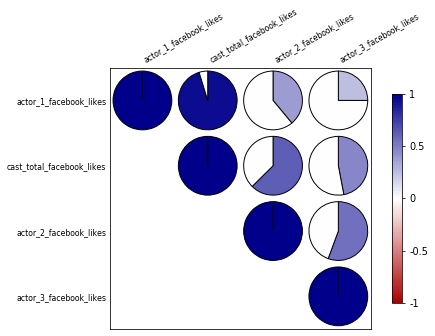

In [83]:
fb_cols = ['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes']
fb_movies = movies[fb_cols]

plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (7,5)
c = corrplot.Corrplot(fb_movies.corr())
c.plot(method='pie', upper='pie', shrink= .9, grid=False, fontsize=8)
plt.show()

Ces variables sont linéairement corrélées, pour plus de détails, j’ai fait une analyse ACP  

J'effectue préalablement un "simple nettoyage" de données en remplaçant les valeurs manquantes par la médiane (étant plus robuste aux outliers)

In [85]:
# fonctions renvoyant les 3 quartiles pour une colonne donnée.
def median(col):
    return movies[col].quantile(.5)  # deuxième quartile

# remplacer les manquants par la médiane
for col in pca_cols:
    fb_movies[col] = fb_movies[col].fillna(median(col))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


**L'ACP**

In [86]:
from sklearn import preprocessing;
D = fb_movies.values
std_scale = preprocessing.StandardScaler().fit(D)
D_scaled = std_scale.transform(D)

from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(D_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[ 0.66469671  0.22948684]
0.894183546992


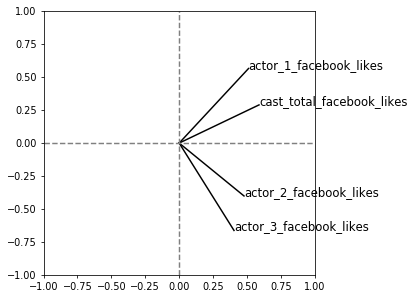

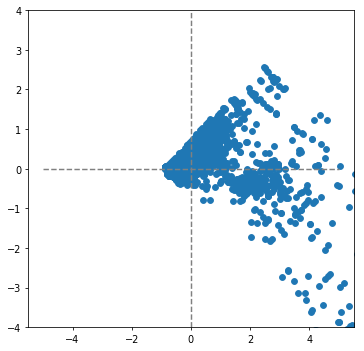

In [99]:
pcs = pca.components_

plt.figure(figsize=(5,5))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) 
    plt.text(x, y, fb_movies.columns[i], fontsize='12')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

###  affichage nuage de points 
fig = plt.figure(figsize=(6,6))
# projeter D sur les composantes principales
D_projected = pca.transform(D_scaled)

# Afficher une ligne horizontale y=0
plt.plot([-5, 5], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-4, 4], color='grey', ls='--')

# afficher chaque observation
plt.scatter(
    D_projected[:, 0],
    D_projected[:, 1],
)
plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.show()

Clairement, il y ‘a un effet « **taille** » , toutes ces variables sont de même signe sur le premier axe factoriel  et elles sont **toutes corrélées positivement entre elles** .

L'axe principale oppose simplement les films les "plus likés" (au sens global) aux autres !

Par ailleurs, **le premier axe seul**, « *explique* » presque **70%** de l’information (la variance)   
Je **résume** alors désormais ces variables par une **seule**, c’est justement **la projection sur le premier axe factoriel**,  je l’appelle **fb_likes_scaled**

In [124]:
fb_likes_scaled = D_projected[:, [0]]
fb_likes_scaled

array([[-0.3757853 ],
       [ 2.8780533 ],
       [-0.04906923],
       ..., 
       [-0.88840797],
       [-0.57297924],
       [-0.87352651]])

Remarquons au passage que le **imdb_score** est bien **compris entre 0 et 10** et n’a pas de valeurs aberrantes

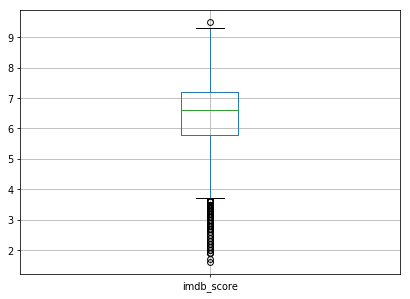

In [235]:
movies.boxplot(column=['imdb_score'])
plt.show()

Je veux construire mon coefficient de popularité, comme suit :


** Popuplarity = imdb_score + fb_likes ** 

imdb_score est fourni dans le data_set , mais pour donner dans cette somme **la même importance** aux deux membres, je commence par **centrer et réduire** la variable **imdb_score**


In [103]:
imdb = (movies['imdb_score'].values).reshape(-1, 1)
imdb_scaled = preprocessing.StandardScaler().fit(imdb).transform(imdb)
imdb_scaled

array([[ 1.29799847],
       [ 0.58625143],
       [ 0.31934629],
       ..., 
       [-0.12549561],
       [-0.12549561],
       [ 0.14140953]])

Et ci-dessous la matrice colonne de la popularité des films  

<span style="color:green">**popularity = fb_likes_scaled + imdb_scaled**<span>

In [125]:
popularity = fb_likes_scaled + imdb_scaled
popularity


array([[ 0.92221317],
       [ 3.46430473],
       [ 0.27027706],
       ..., 
       [-1.01390358],
       [-0.69847485],
       [-0.73211699]])

Je redéfinie la fonction « nearest » qui renvoie désormais les films les plus proches, en tenant compte de la popularité si distances égales.

In [127]:
# renvoi les n  films les plus similaires  au film passé en parametre idx_movie en tenant
# compte de la popularité si distance égale 
from operator import itemgetter
def nearest(idx_movie, n, distanceX = X): 
    max_dist = sorted(distanceX[idx_movie])[n:n+1:]
    s = sorted(
        [(i, dist, popularity[i][0]) for i, dist in enumerate(distanceX[idx_movie]) if dist <= max_dist and i != idx_movie],
        key=itemgetter(2),
        reverse=True
    )
    return sorted(s, key=itemgetter(1))[0:n:]

In [236]:
nearest(10, 5)

[(15, 0.75, 1.5013952648586799),
 (8, 0.82499999999999996, 11.097618668111455),
 (27, 0.82499999999999996, 8.458621532785461),
 (542, 0.82499999999999996, 0.98152911973990176),
 (65, 0.84999999999999998, 4.4314248439414339)]

# Génération du script SQL et mise en ligne

A l’aide de la fonction, « nearest » j’alimente une table **movie** qui contient pour chaque film les informations suivantes:
- L’id du film
- Le titre du film
- L’url IMDB du film
- Et les id des 10 films les plus proches

Une api (python/Falsk) est disponible en ligne pour pouvoir interroger le service en passant un id de film ou un titre.


**Un exemple d’appel par id :**

curl -G  "https://op-proj3.herokuapp.com/movie/5/nearest/"  --data-urlencode "id=200"
 
**Un exemple d’appel par titre :**

curl -G  "https://op-proj3.herokuapp.com/movie/5/nearest/"  --data-urlencode "title=Harry Potter and the Sorcerer's Stone"

**Résultat :** 

[  
    {
        "id": 282,
        "title": "Harry Potter and the Chamber of Secrets"
    },  
    {
        "id": 193,
        "title": "Harry Potter and the Prisoner of Azkaban"
    },  
    {
        "id": 114,
        "title": "Harry Potter and the Order of the Phoenix"
    },  
    {
        "id": 115,
        "title": "Harry Potter and the Goblet of Fire"
    },  
    {
        "id": 347,
        "title": "Percy Jackson & the Olympians: The Lightning Thief"
    }  
    ]



In [210]:
import unicodedata
def nz(string):
    return unicodedata.normalize("NFKD", string).replace("'","''").strip()
insert_values = [ '('+
                 ','.join([str(idx), "'"+nz(row['movie_title'])+"'", "'"+nz(row['movie_imdb_link'])+"'","'{"+ ','.join([str(x[0]) for x in nearest(idx,10)]) + "}'::INTEGER[]"])
                 +')'
                 for idx, row in movies.iterrows()  
                ]

In [212]:
script_sql = 'INSERT INTO movie (id, title, url, neighbors) VALUES '+','.join(insert_values)